In [139]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star import maze_plot
import pickle
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
from magic import ordinator
import cv2

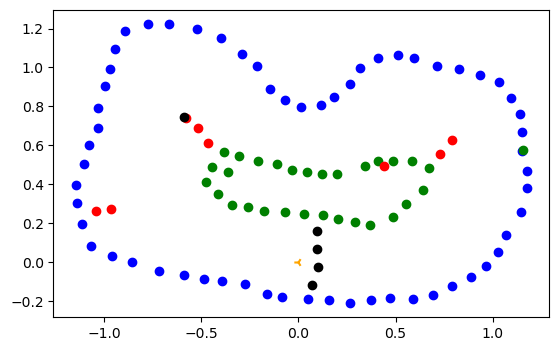

Missing 2 nodes to close the polygon; min_dist = 0.6166924746522137


In [140]:
# with open(r"SLAM20240124_101335.pickle", "rb") as input_file:
with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.show()


positions_array = np.array(positions)
positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)

ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]


pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext,max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step=0.03
max_x=np.max(external_ordered[:,0])
max_y=np.max(external_ordered[:,1])
min_x=np.min(external_ordered[:,0])
min_y=np.min(external_ordered[:,1])
delta_x=max_x-min_x
delta_y=max_y-min_y
center_x=min_x+delta_x/2
center_y=min_y+delta_y/2

n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)

x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask = np.array([[ext_ordered_poly.contains(Point(x[i], y[j])) and not int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

mask = 1-mask

In [141]:
def find_checkpoint_in_quadrant(maze, x_range, y_range):
    for y in range(y_range[0], y_range[1]):
        for x in range(x_range[0], x_range[1]):
            if maze[x, y] == 0:
                return (x, y)
    return None  # If no suitable point is found

# def find_checkpoint_in_quadrant_right(maze, x_range, y_range):
#     furthest_point = None
#     for y in range(y_range[0], y_range[1]):
#         for x in range(x_range[1]-1, x_range[0]-1, -1): # Iterate in reverse order
#             if maze[x, y] == 0:
#                 furthest_point = (x, y)
#     return furthest_point # Return the furthest suitable point

def find_checkpoint_in_quadrant_right(maze, x_range, y_range, limit=100):
    furthest_point = None
    count = 0
    for y in range(y_range[0], y_range[1]):
        for x in range(x_range[1]-1, x_range[0]-1, -1): # Iterate in reverse order
            if maze[x, y] == 0:
                furthest_point = (x, y)
                count += 1
                if count >= limit:
                    break
        if count >= limit:
            break
    return furthest_point # Return the furthest suitable point within the limit


def generate_quadrant_checkpoints(maze):
    height, width = maze.shape
    checkpoints = []
    
    # Quadrants: [(x_range, y_range), ...]
    quadrants = [
        ((height//2, height), (width//2, width)),  # Lower-Right
        ((0, height//2), (width//2, width)),       # Upper-Right
        ((0, height//2), (0, width//2)),           # Upper-Left
        # ((height//2, height), (0, width//2)),      # Lower-Left
    ]

    # for quadrant in quadrants:
    #     checkpoint = find_checkpoint_in_quadrant(maze, *quadrant)
    #     if checkpoint:
    #         checkpoints.append(checkpoint)

    for quadrant in quadrants:
        if quadrant == ((height//2, height), (width//2, width)): # If it's the lower-right quadrant
            checkpoint = find_checkpoint_in_quadrant_right(maze, *quadrant) # Use a different function
        else:
            checkpoint = find_checkpoint_in_quadrant(maze, *quadrant)
        if checkpoint:
            checkpoints.append(checkpoint)


    return checkpoints

In [142]:
checkpoints = generate_quadrant_checkpoints(mask)
print(checkpoints)
print(mask.shape)

[(25, 36), (1, 25), (8, 1)]
(32, 51)


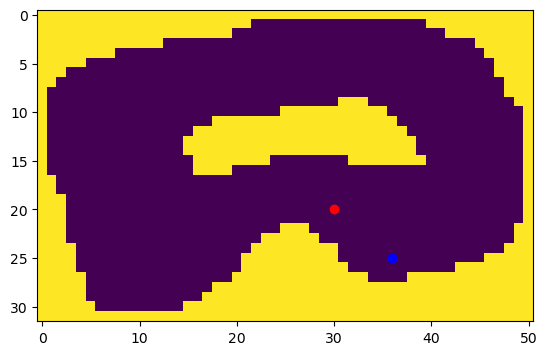

(32, 51)


In [143]:
#################################
# Change start according to map
#################################

start = (20,30)
# start = (70,30)

plt.imshow(mask, interpolation='nearest', origin='upper')
# plt.axvline(center_x, color='blue')
plt.scatter(start[1], start[0], color='red')

i = 0
plt.scatter(checkpoints[i][1], checkpoints[i][0], color="blue")
# plt.scatter(20,70, color="red")

plt.show()
mask.shape

# print(mask[70][20])
print(mask.shape)

In [144]:
def heuristic_(a, b):
    # Chebyshev distance
    (x1, y1) = a
    (x2, y2) = b
    return max(abs(x1 - x2), abs(y1 - y2))

def astar(maze, start, end):
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0),
             (1, 1), (-1, -1), (-1, 1), (1, -1)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic_(start, end)}
    oheap = []
    open_set_hash = set([start])  # To check efficiently if a node is in the open set

    def neighbors_available(position):
        neighbors = []
        for move in moves:
            x_test, y_test = position[0] + move[0], position[1] + move[1]
            if 0 <= x_test < maze.shape[0] and 0 <= y_test < maze.shape[1]:
                if maze[x_test, y_test] != 1:
                    neighbors.append((x_test, y_test))
        return neighbors

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]
        open_set_hash.remove(current)

        if current == end:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data[::-1]  # Reversing the path

        close_set.add(current)
        for neighbor in neighbors_available(current):
            tentative_g_score = gscore[current] + 1

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in open_set_hash:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic_(neighbor, end)
                if neighbor not in open_set_hash:
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))
                    open_set_hash.add(neighbor)

    return False

def astar_with_checkpoints(maze, start, checkpoints):
    path = []
    current_start = start

    for checkpoint in checkpoints:
        segment = astar(maze, current_start, checkpoint)
        if segment:
            path.extend(segment)
            current_start = checkpoint
        else:
            print(f"Path not found for segment to checkpoint {checkpoint}")
            return None  # Path not found for a segment

    # Optional: return to start
    return_to_start_segment = astar(maze, current_start, start)
    if return_to_start_segment:
        path.extend(return_to_start_segment)

    return path


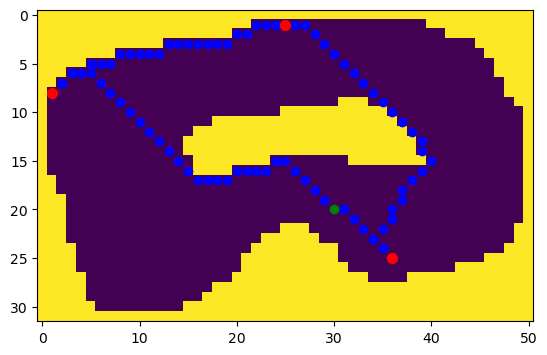

[(20, 30), (19, 29), (18, 28), (17, 27), (16, 26), (15, 25), (15, 24), (16, 23), (16, 22), (16, 21), (16, 20), (17, 19), (17, 18), (17, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (6, 4), (6, 3), (7, 2), (8, 1), (7, 2), (6, 3), (6, 4), (5, 5), (5, 6), (5, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (2, 20), (2, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (2, 28), (3, 29), (4, 30), (5, 31), (6, 32), (7, 33), (8, 34), (9, 35), (10, 36), (11, 37), (12, 38), (13, 39), (14, 39), (15, 40), (16, 39), (17, 38), (18, 37), (19, 37), (20, 36), (21, 36), (22, 35), (23, 34), (24, 35), (25, 36), (24, 35), (23, 34), (22, 33), (21, 32), (20, 31)]


In [145]:
def maze_plot_with_checkpoints(maze, start, checkpoints):

    # Using the modified A* function for checkpoints
    full_path = astar_with_checkpoints(maze, start, checkpoints)
    if full_path is None:
        print("Path not found")
        return

    plt.imshow(maze, origin='upper')

    # Plot the path
    for point in full_path:
        plt.scatter(point[1], point[0], color='blue')  # Ensure correct order for x, y plotting

    # Plot the checkpoints and the start
    plt.scatter(start[1],start[0], color='green')
    for checkpoint in checkpoints:
        plt.scatter(checkpoint[1], checkpoint[0], color='red', s=50)

    plt.show()
    
    # Convert path back to original coordinate system if necessary
    # full_path = [(x[1], x[0]) for x in full_path]
    print(full_path[::-1])  # Print the path in the original coordinate system


maze_plot_with_checkpoints(mask, start, checkpoints)